# Aestimo Tutorial #5

In this tutorial, we are going to model optical intersubband transitions between the conduction subbands of a quantum well. In the conduction band, intersubband transitions only couple to the electric field component across the structure (along the growth direction/perpendicular to the plane of the quantum well etc)[ref]. This means that the medium is anisotropic which leads to interesting properties like a shift in the absorption frequency due to a 'depolarisation shift'[ref] as well as standing wave effects[ref]. I could go on about this for a while [my ref] but instead, let's cut straight to the action.

First we will model a 'normal' quantum well structure

In [1]:
import aestimo.aestimo as solver
import aestimo.config as ac
ac.messagesoff = True # turn off logging in order to keep notebook from being flooded with messages.
import aestimo.database as adatabase
import numpy as np
import matplotlib.pyplot as plt
import copy
from pprint import pprint
%matplotlib inline

ModuleNotFoundError: No module named 'aestimo'

In [ ]:
class Structure(object): pass
s1 = Structure() # this will be our datastructure

# TEMPERATURE
s1.T = 15.0 #Kelvin

# COMPUTATIONAL SCHEME
# 0: Schrodinger
# 1: Schrodinger + nonparabolicity
# 2: Schrodinger-Poisson
# 3: Schrodinger-Poisson with nonparabolicity
# 4: Schrodinger-Exchange interaction
# 5: Schrodinger-Poisson + Exchange interaction
# 6: Schrodinger-Poisson + Exchange interaction with nonparabolicity
s1.computation_scheme = 6

# Non-parabolic effective mass function
# 0: no energy dependence
# 1: Nelson's effective 2-band model
# 2: k.p model from Vurgaftman's 2001 paper
s1.meff_method = 2

# Non-parabolic Dispersion Calculations for Fermi-Dirac
s1.fermi_np_scheme = True #needed only for aestimo_numpy2.py

# QUANTUM
# Total subband number to be calculated for electrons
s1.subnumber_e = 3

# APPLIED ELECTRIC FIELD
s1.Fapplied = 0.00 # (V/m)

# GRID
# For 1D, z-axis is choosen
s1.gridfactor = 0.1 #nm
s1.maxgridpoints = 200000 #for controlling the size

# REGIONS
# Region input is a two-dimensional list input.
#         | Thickness (nm) | Material | Alloy fraction | Doping(cm^-3) | n or p type |
s1.material =[
            [ 20.0, 'AlGaAs', 0.3, 0.0, 'n'],
            [ 11.0, 'GaAs', 0, 2e18, 'n'],
            [ 20.0, 'AlGaAs', 0.3, 0.0, 'n'],
            ]

structure1 = s1

In [2]:
# Initialise structure class
model1 = solver.StructureFrom(structure1,adatabase) # structure could also be a dictionary.
    
#calculate QW states
result1 = solver.Poisson_Schrodinger(model1)

#solver.save_and_plot(result,model) # Write the simulation results in files
solver.QWplot(result1,figno=None) # Plot QW diagram
solver.logger.info("Simulation is finished.")

NameError: name 'solver' is not defined

Now we will calculate the intersubband transitions using the appropriately named 'intersubband_optical_transitions' module. The module contain several different models starting with semiclassical models and finishing with a perturbative quantum mechanical model that accounts for collective interactions between all of the transitions. The theory behind the intersubband transitions is a little more complicated than might be expected, see [?] for details.

In [3]:
import aestimo.intersubband_optical_transitions as isbt

# set dielectric constants
case = 2

if case==1: #scalar dielectric constants
    eps_b = 12.90
    eps_z = 12.90

elif case==2: #z-dependent dielectric constants
    eps_b = 10.364
    eps_gaas = 10.364 # @ 16um
    eps_algaas = 8.2067
    #eps_z = isbt.eps_background_GaAs(model,eps_gaas,eps_algaas)
    
    eps_z = np.zeros(model1.n_max)
    position = 0.0 # keeping in nanometres (to minimise errors)
    for layer in model1.material:
        startindex = solver.round2int(position*1e-9/model1.dx)
        position += layer[0] # update position to end of the layer
        finishindex = solver.round2int(position*1e-9/model1.dx)
        #
        matType = layer[1]
        if matType == 'GaAs':
            eps_z[startindex:finishindex] = eps_gaas
        elif matType == 'AlGaAs':
            eps_z[startindex:finishindex] = eps_algaas
    
elif case==3: #w-dependent dielectric constants
    #because the zeroth axis is assumed to be the z-axis, our eps_z array must be 2d
    pass
    #currently the matrix model doesn't cope with frequency dependent dielectric constants
    #therefore the classical model would be the best approach (model2) although it seems
    #to over-estimate the coupling between the transitions.
    #Alternatively, we could resolve the matrix at each frequency (for each value of the
    #background dielectric constant which would be accurate but may be quite computationally
    #intensive.

elif case==4: #z-dependent and w-dependent dielectric constants
    pass
    #currently the matrix model doesn't cope with frequency dependent dielectric constants
    #therefore the classical model is the best approach (model2) although it seems
    #to over-estimate the coupling between the transitions.
    #Alternatively, we could resolve the matrix at each frequency (for each value of the
    #background dielectric constant which would be accurate but may be quite computationally
    #intensive.

#Set thickness of effective medium
#Lperiod = sum([layer[0] for layer in model.material])*1e-9 #m
Lperiod = model1.x_max #m

# Define Linewidth function (or constant)
def linewidth(freq): return 0.1*freq #define linewidth in THz

# Optical Intersubband Transitions
transitions_table,(hdr,units) = isbt.transitions(result1,Lperiod,eps_z,linewidth)

isbt.print_levels(result1)
isbt.print_transitions(transitions_table,hdr,units)
    

ModuleNotFoundError: No module named 'aestimo'

In [1]:
# Save default rcParams so we can reset them later
# WARNING: Do not run this cell after changing rcParams, as it will overwrite the
# defaults that we are trying to preserve.
rcdef = plt.rcParams.copy()

NameError: name 'plt' is not defined

In [3]:
newparams = {'savefig.dpi': 120, 'legend.fontsize': 'smaller'}
#newparams = {'axes.labelsize': 14, 'axes.linewidth': 1, 'savefig.dpi': 150, 
#             'lines.linewidth': 1.5, #'figure.figsize': (8, 3),
#             'figure.subplot.wspace': 0.4,
#             'ytick.labelsize': 12, 'xtick.labelsize': 12,
#             'ytick.major.pad': 5, 'xtick.major.pad': 5,
#             'legend.fontsize': 12, 'legend.frameon': False, 
#             'legend.handlelength': 1.5}

# Update the global rcParams dictionary with the new parameter choices
# Before doing this, we reset rcParams to its default again, just in case
plt.rcParams.update(rcdef)
plt.rcParams.update(newparams)
isbt.plotting_absorption(model1,result1,transitions_table,eps_b,eps_z,linewidth)

NameError: name 'plt' is not defined

In the plot above, the vertical blue lines mark the energy gaps between the quantum well's energy levels. We can also see that apart from the 'naive' model, the three different models are almost in agreement for this case. The result shows that the absorption strength of the lower transition has been shifted to a higher frequency which is an example of the 'depolarisation shift'. It also appears that the first and second transitions have almost merged, in fact we often find that when transitions are close, the higher energy transition will 'steal' the transition strength of the lower one due to the coulombic interactions between the different transitions.

Let's model an even wider quantum well to show what happens when there are many transtions interacting. 

In [7]:
structure2 = copy.copy(structure1)

# DOPING
Nd = 1e18

structure2.material =[
            [ 10.0, 'AlGaAs', 0.3, 0.0, 'n'],
            [ 30.0, 'GaAs', 0, Nd, 'n'],
            [ 10.0, 'AlGaAs', 0.3, 0.0, 'n']]

structure2.subnumber_e = 7
 

# Initialise structure class
model2 = solver.StructureFrom(structure2,adatabase) # structure could also be a dictionary.

Total layer number: 3
INFO:aestimo:Total layer number: 3
Total number of materials in database: 20
INFO:aestimo:Total number of materials in database: 20


This example also allows me to show that sometimes the Poisson-Schrodinger algorithm needs to be optimised. Using the standard parameters, we get weird results. If we run aestimo on the command-line we can see how the energy-state solutions evolve as the algorithm iterates; if we looked at the output for this simulation, we would see that the solutions are drastically changing between each iteration, the algorithm has gone into oscillations rather than tending towards the correct solution. There will probably be a warning that aestimo has reached the maximum number of iterations.

The calculation of Vxc depends upon m*, however when non-parabolicity is also 
                 considered m* becomes energy dependent which would make Vxc energy dependent.
                 Currently this effect is ignored and Vxc uses the effective masses from the 
                 bottom of the conduction bands even when non-parabolicity is considered 
                 elsewhere.
                 considered m* becomes energy dependent which would make Vxc energy dependent.
                 Currently this effect is ignored and Vxc uses the effective masses from the 
                 bottom of the conduction bands even when non-parabolicity is considered 
                 elsewhere.
Have reached maximum number of iterations
calculation time  28.4882 s
INFO:aestimo:calculation time  28.4882 s


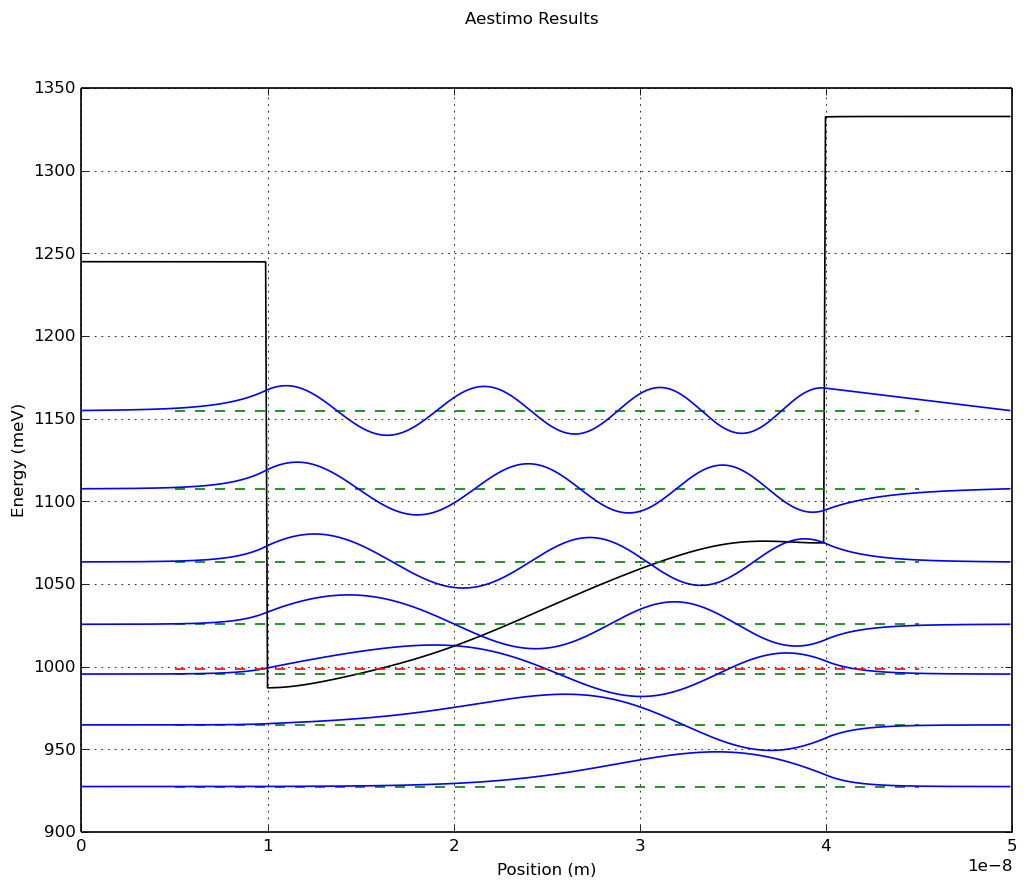

Simulation is finished.
INFO:aestimo:Simulation is finished.


In [8]:
ac.damping = 0.5 # standard value of this parameter

#calculate QW states
result2 = solver.Poisson_Schrodinger(model2)

#solver.save_and_plot(result,model) # Write the simulation results in files
solver.QWplot(result2,figno=None) # Plot QW diagram
solver.logger.info("Simulation is finished.")

Now, we change one of the parameters in the configuration module so that the algorithm is more 'damped'. This allows the algorithm to find the correct solution.

The calculation of Vxc depends upon m*, however when non-parabolicity is also 
                 considered m* becomes energy dependent which would make Vxc energy dependent.
                 Currently this effect is ignored and Vxc uses the effective masses from the 
                 bottom of the conduction bands even when non-parabolicity is considered 
                 elsewhere.
                 considered m* becomes energy dependent which would make Vxc energy dependent.
                 Currently this effect is ignored and Vxc uses the effective masses from the 
                 bottom of the conduction bands even when non-parabolicity is considered 
                 elsewhere.
calculation time  13.1024 s
INFO:aestimo:calculation time  13.1024 s


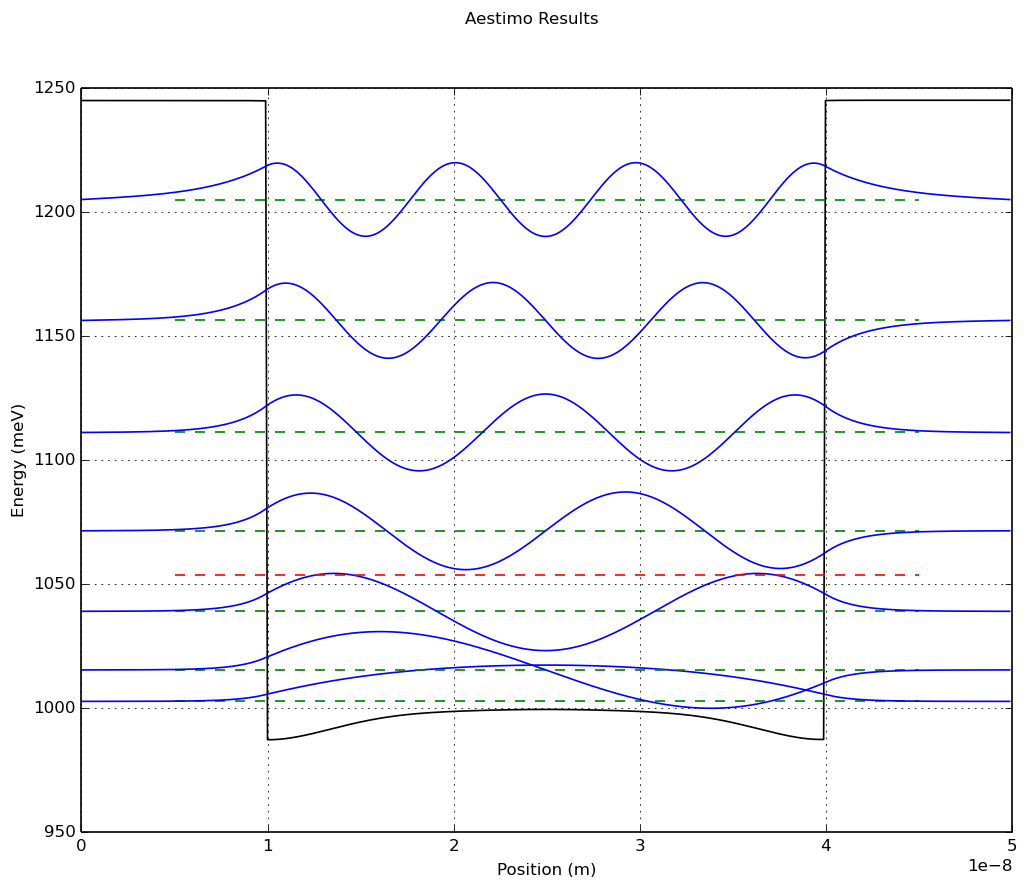

Simulation is finished.
INFO:aestimo:Simulation is finished.


In [9]:
# Optimise stability of Poisson-Schrodinger Algorithm
ac.damping = 0.3

#calculate QW states
result2 = solver.Poisson_Schrodinger(model2)

#solver.save_and_plot(result,model) # Write the simulation results in files
solver.QWplot(result2,figno=None) # Plot QW diagram
solver.logger.info("Simulation is finished.")

the energy levels\population are (meV)	(m**-2):
1002.6711201 	1.46719235946e+16
1015.35054274 	1.10726949424e+16
1038.98843046 	4.25538108207e+15
1071.45064758 	380985223.243
1111.09427639 	1.88101113359e-05
1156.27202141 	1.2894960289e-20
1205.02071946 	3.01884620543e-37

T = 15K

the energy levels gaps are
(meV)	(THz)	(um)	(wavno)
12.7	3.07	97.8	102
36.3	8.78	34.1	293
68.8	16.6	18	555
108	26.2	11.4	874
154	37.1	8.07	1.24e+03
202	48.9	6.13	1.63e+03
23.6	5.72	52.5	191
56.1	13.6	22.1	452
95.7	23.2	12.9	772
141	34.1	8.8	1.14e+03
190	45.9	6.54	1.53e+03
32.5	7.85	38.2	262
72.1	17.4	17.2	582
117	28.4	10.6	946
166	40.1	7.47	1.34e+03
39.6	9.59	31.3	320
84.8	20.5	14.6	684
134	32.3	9.28	1.08e+03
45.2	10.9	27.4	364
93.9	22.7	13.2	758
48.7	11.8	25.4	393
Summary of Intersubband Transitions
       j                        0          1          2          3
  ilevel                        0          0          0          0
  flevel                        1          2          3          4
      dE  

(0.0, 30)

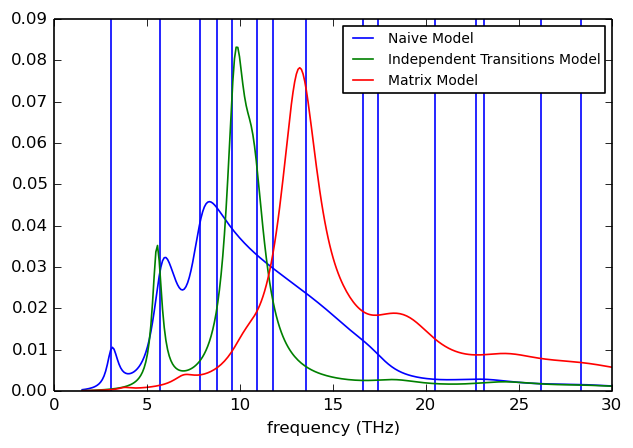

In [10]:
# set dielectric constants
case = 2

if case==1: #scalar dielectric constants
    eps_b2 = 12.90
    eps_z2 = 12.90

elif case==2: #z-dependent dielectric constants
    eps_b2 = 10.364
    eps_gaas = 10.364 # @ 16um
    eps_algaas = 8.2067
    eps_z2 = np.zeros(model2.n_max)
    
    position = 0.0 # keeping in nanometres (to minimise errors)
    for layer in model1.material:
        startindex = solver.round2int(position*1e-9/model2.dx)
        position += layer[0] # update position to end of the layer
        finishindex = solver.round2int(position*1e-9/model2.dx)
        #
        matType = layer[1]
        if matType == 'GaAs':
            eps_z2[startindex:finishindex] = eps_gaas
        elif matType == 'AlGaAs':
            eps_z2[startindex:finishindex] = eps_algaas

#Set thickness of effective medium
#Lperiod = sum([layer[0] for layer in model.material])*1e-9 #m
Lperiod2 = model2.x_max #m

# Optical Intersubband Transitions
transitions_table2,(hdr,units) = isbt.transitions(result2,Lperiod2,eps_z2,linewidth)
    
isbt.print_levels(result2)
isbt.print_transitions(transitions_table2,hdr,units)

#plot output
isbt.plotting_absorption(model2,result2,transitions_table2,eps_b2,eps_z2,linewidth)

plt.gca().set_xlim(xmax=30)

So when there are multiple transitions, we can see that the matrix model gives a very different result compared to treating the transitions independently. In general, we find that the frequency of the absorption will be at a higher frequency than expected and most of the transition strength will be concentrated into a single transition.

1. T. Ando, "Intersubband optical absorption in space-charge layers on semiconductor surfaces", Z. PHysik B, 26, 263-272 (1977)
2. G. Pegolotti, A. Vasanelli, Y. Todorov and C. Sirtori, "Quantum model of coupled intersubband plasmons Phys. Rev. B 90, 035305 (2014)